
### Experiment 3: Augmentation Tuning ##
**training data:** train

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 23.4441, Train Acc: 0.3768, Val Loss: 8.6404, Val Acc: 0.5500
Epoch 2, Train Loss: 17.4738, Train Acc: 0.6071, Val Loss: 6.2970, Val Acc: 0.7708
Epoch 3, Train Loss: 13.4006, Train Acc: 0.7054, Val Loss: 6.1395, Val Acc: 0.7208
Epoch 4, Train Loss: 11.2529, Train Acc: 0.7661, Val Loss: 4.0001, Val Acc: 0.8458
Epoch 5, Train Loss: 8.8582, Train Acc: 0.8411, Val Loss: 5.7424, Val Acc: 0.7500
Epoch 6, Train Loss: 9.2132, Train Acc: 0.8036, Val Loss: 4.7326, Val Acc: 0.7750
Epoch 7, Train Loss: 7.3287, Train Acc: 0.8518, Val Loss: 3.6096, Val Acc: 0.8667
Epoch 8, Train Loss: 6.6615, Train Acc: 0.8804, Val Loss: 3.3983, Val Acc: 0.8542
Epoch 9, Train Loss: 5.5723, Train Acc: 0.8893, Val Loss: 3.9052, Val Acc: 0.8333
Epoch 10, Train Loss: 5.4272, Train Acc: 0.8929, Val Loss: 2.9797, Val Acc: 0.8792
Epoch 11, Train Loss: 4.9579, Train Acc: 0.9179, Val Loss: 3.0683, Val Acc: 0.8750
Epoch 12, Train Loss: 4.19

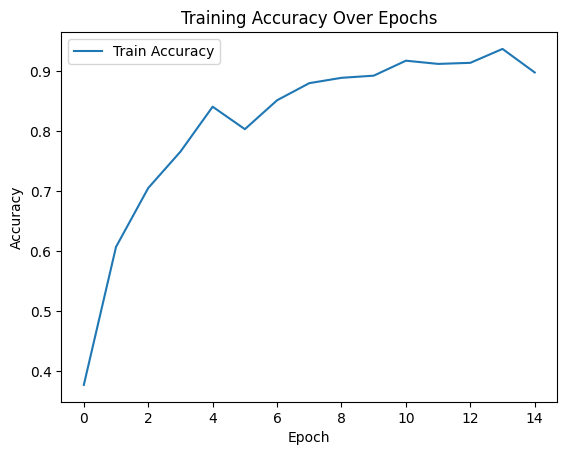

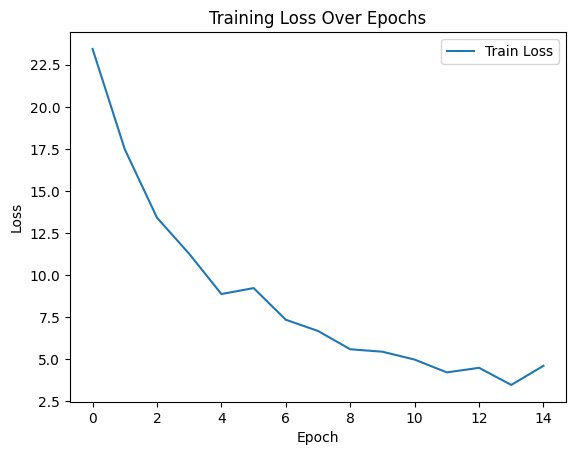

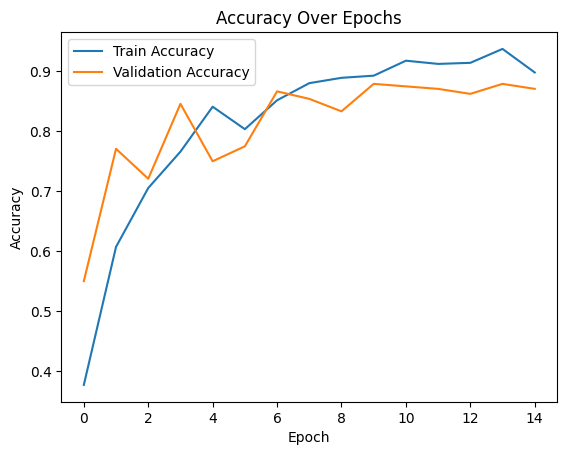

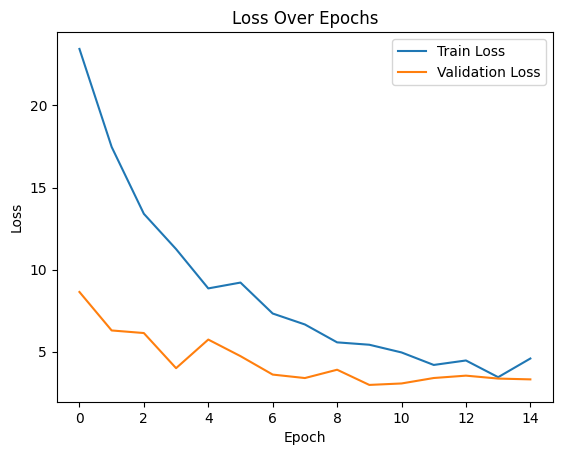

In [1]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])

# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),                                  # ReLU activation
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.3),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 1st Run ##
**training data:** augmented_tain_1 & 70% of train

In [2]:
# do augmentation
import os
from PIL import Image
import torchvision.transforms as transforms
import random
import torch

random.seed(42)
torch.manual_seed(42)

augmentation = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomVerticalFlip(p=1.0),
    ], p=0.5),

    transforms.RandomApply([
        transforms.RandomRotation(degrees=30),
    ], p=0.8),

    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0.1),  
            scale=(0.95, 1.05),    
            shear=5               
        ),
    ], p=0.7),

    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.3,
            contrast=0.3,
            saturation=0.3,
            hue=0.02
        ),
    ], p=0.8),

    transforms.RandomApply([
        transforms.RandomGrayscale(p=1.0),
    ], p=0.2),

    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3),
    ], p=0.3),
])

# script_dir = os.path.dirname(os.path.abspath(__file__))
input_root = "../train"
output_root = "augmented_train_1"
aug_per_image = 5

if not os.path.exists(input_root):
    raise FileNotFoundError(f"input root not exist: {os.path.abspath(input_root)}")


for class_name in os.listdir(input_root):
    input_class_path = os.path.join(input_root, class_name)
    output_class_path = os.path.join(output_root, class_name)

    if not os.path.isdir(input_class_path):
        continue

    os.makedirs(output_class_path, exist_ok=True)

    for img_name in os.listdir(input_class_path):
        img_path = os.path.join(input_class_path, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"skip damage image: {img_path}")
            continue

        for i in range(aug_per_image):
            aug_img = augmentation(image)
            save_path = os.path.join(
                output_class_path,
                f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
            )
            aug_img.save(save_path)

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 145.3139, Train Acc: 0.5509, Val Loss: 3.2959, Val Acc: 0.8625
Epoch 2, Train Loss: 105.6327, Train Acc: 0.7182, Val Loss: 3.1316, Val Acc: 0.8750
Epoch 3, Train Loss: 88.8090, Train Acc: 0.7572, Val Loss: 2.6449, Val Acc: 0.8875
Epoch 4, Train Loss: 82.7084, Train Acc: 0.7798, Val Loss: 1.9181, Val Acc: 0.9042
Epoch 5, Train Loss: 74.6387, Train Acc: 0.7989, Val Loss: 2.3836, Val Acc: 0.9000
Epoch 6, Train Loss: 67.3137, Train Acc: 0.8257, Val Loss: 1.8036, Val Acc: 0.9167
Epoch 7, Train Loss: 62.5451, Train Acc: 0.8357, Val Loss: 1.6910, Val Acc: 0.9208
Epoch 8, Train Loss: 57.5082, Train Acc: 0.8447, Val Loss: 1.5444, Val Acc: 0.9333
Epoch 9, Train Loss: 52.2983, Train Acc: 0.8592, Val Loss: 1.0928, Val Acc: 0.9542
Epoch 10, Train Loss: 46.0577, Train Acc: 0.8772, Val Loss: 1.7857, Val Acc: 0.9125
Epoch 11, Train Loss: 42.0105, Train Acc: 0.8917, Val Loss: 0.8236, Val Acc: 0.9625
Epoch 12, Train L

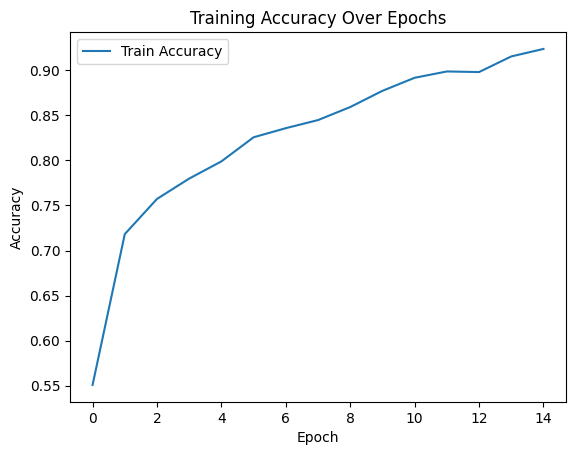

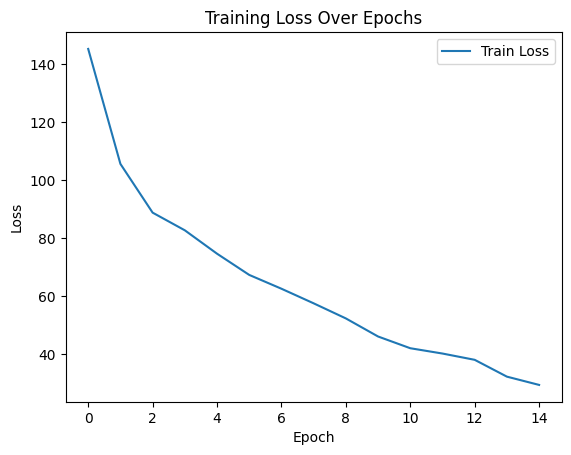

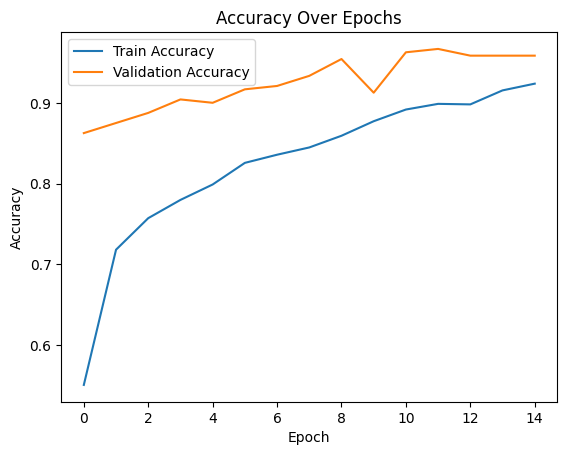

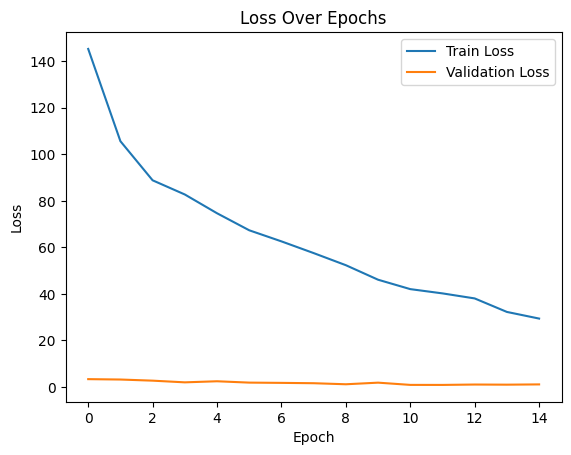

In [3]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
original_path = "../train"
augmented_path = "augmented_train_1"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])

# Load training and test datasets using folder structure
original_data = ImageFolder(original_path,transform=transform_train)
augmented_data = ImageFolder(augmented_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(original_data))
val_size = len(original_data) - train_size
original_train, val_dataset = random_split(original_data, [train_size,val_size])

from torch.utils.data import ConcatDataset
train_dataset = ConcatDataset([original_train,augmented_data])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", test_data.classes)

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),                                  # ReLU activation
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.3),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 2nd Run ##
**training data:** augmented_tain_2 & 70% of train

In [5]:
# do augmentation
import os
from PIL import Image
import torchvision.transforms as transforms
import random
import torch

random.seed(42)
torch.manual_seed(42)

augmentation = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomVerticalFlip(p=1.0),
    ], p=0.5),

    transforms.RandomApply([
        transforms.RandomRotation(degrees=30),
    ], p=0.8),

    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0.1),  
            scale=(0.95, 1.05),    
            shear=5               
        ),
    ], p=0.7),

    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.3,
            contrast=0.3,
            saturation=0.3,
            hue=0.02
        ),
    ], p=0.8),

    transforms.RandomApply([
        transforms.RandomGrayscale(p=1.0),
    ], p=0.05), #0.2->0.05

    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3),
    ], p=0.3),

    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.ToPILImage()
])

# script_dir = os.path.dirname(os.path.abspath(__file__))
input_root = "../train"
output_root = "augmented_train_2"
aug_per_image = 5

if not os.path.exists(input_root):
    raise FileNotFoundError(f"input root not exist: {os.path.abspath(input_root)}")


for class_name in os.listdir(input_root):
    input_class_path = os.path.join(input_root, class_name)
    output_class_path = os.path.join(output_root, class_name)

    if not os.path.isdir(input_class_path):
        continue

    os.makedirs(output_class_path, exist_ok=True)

    for img_name in os.listdir(input_class_path):
        img_path = os.path.join(input_class_path, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"skip damage image: {img_path}")
            continue

        for i in range(aug_per_image):
            aug_img = augmentation(image)
            save_path = os.path.join(
                output_class_path,
                f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
            )
            aug_img.save(save_path)

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 119.5477, Train Acc: 0.6724, Val Loss: 3.9036, Val Acc: 0.8500
Epoch 2, Train Loss: 88.9848, Train Acc: 0.7732, Val Loss: 2.0480, Val Acc: 0.9250
Epoch 3, Train Loss: 77.7052, Train Acc: 0.7919, Val Loss: 1.5877, Val Acc: 0.9333
Epoch 4, Train Loss: 64.5105, Train Acc: 0.8300, Val Loss: 1.5038, Val Acc: 0.9250
Epoch 5, Train Loss: 58.9049, Train Acc: 0.8421, Val Loss: 1.0125, Val Acc: 0.9583
Epoch 6, Train Loss: 52.7605, Train Acc: 0.8632, Val Loss: 0.9506, Val Acc: 0.9625
Epoch 7, Train Loss: 43.2903, Train Acc: 0.8829, Val Loss: 0.7249, Val Acc: 0.9750
Epoch 8, Train Loss: 37.2283, Train Acc: 0.9055, Val Loss: 0.8510, Val Acc: 0.9625
Epoch 9, Train Loss: 34.0705, Train Acc: 0.9136, Val Loss: 0.9991, Val Acc: 0.9583
Epoch 10, Train Loss: 30.9606, Train Acc: 0.9254, Val Loss: 0.9212, Val Acc: 0.9667
Epoch 11, Train Loss: 28.7996, Train Acc: 0.9261, Val Loss: 0.3929, Val Acc: 0.9833
Epoch 12, Train Lo

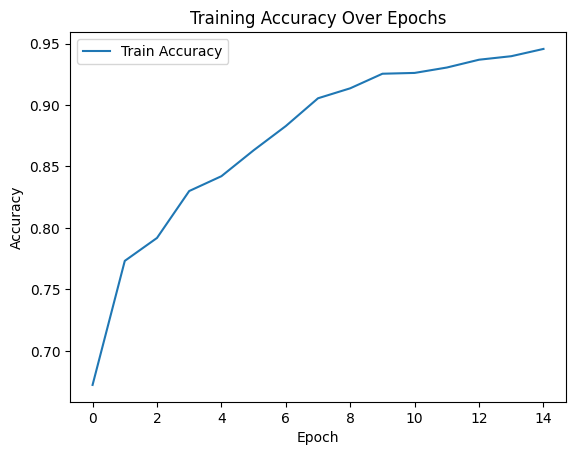

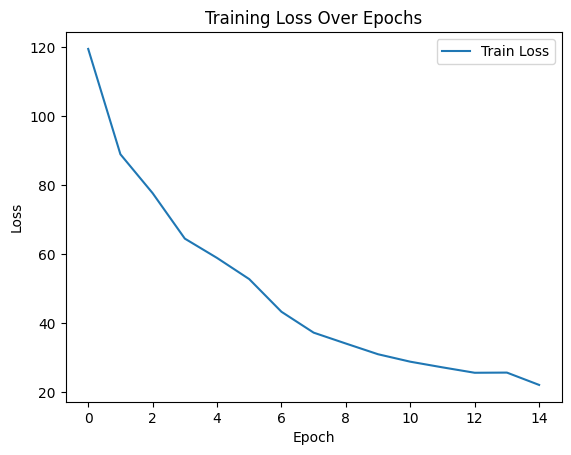

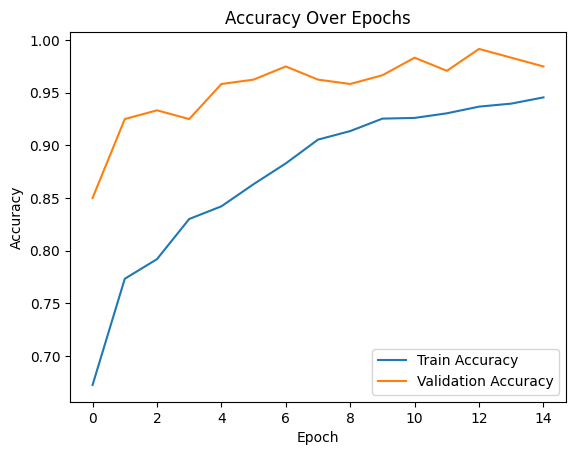

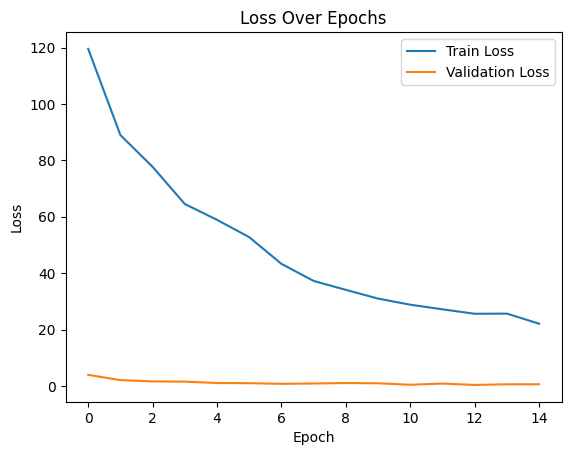

In [6]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
original_path = "../train"
augmented_path = "augmented_train_2"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])

# Load training and test datasets using folder structure
original_data = ImageFolder(original_path,transform=transform_train)
augmented_data = ImageFolder(augmented_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(original_data))
val_size = len(original_data) - train_size
original_train, val_dataset = random_split(original_data, [train_size,val_size])

from torch.utils.data import ConcatDataset
train_dataset = ConcatDataset([original_train,augmented_data])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", test_data.classes)

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),                                  # ReLU activation
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.3),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 117.6444, Train Acc: 0.6638, Val Loss: 4.5804, Val Acc: 0.8125
Epoch 2, Train Loss: 84.0596, Train Acc: 0.7811, Val Loss: 4.0486, Val Acc: 0.8042
Epoch 3, Train Loss: 72.9174, Train Acc: 0.8088, Val Loss: 2.2887, Val Acc: 0.9000
Epoch 4, Train Loss: 60.0922, Train Acc: 0.8443, Val Loss: 2.4001, Val Acc: 0.8958
Epoch 5, Train Loss: 54.4972, Train Acc: 0.8564, Val Loss: 1.4672, Val Acc: 0.9333
Epoch 6, Train Loss: 48.7624, Train Acc: 0.8737, Val Loss: 1.4659, Val Acc: 0.9208
Epoch 7, Train Loss: 40.7502, Train Acc: 0.8914, Val Loss: 1.2789, Val Acc: 0.9542
Epoch 8, Train Loss: 34.5114, Train Acc: 0.9149, Val Loss: 0.8584, Val Acc: 0.9542
Epoch 9, Train Loss: 33.9679, Train Acc: 0.9167, Val Loss: 1.0091, Val Acc: 0.9542
Epoch 10, Train Loss: 29.6220, Train Acc: 0.9239, Val Loss: 0.8069, Val Acc: 0.9583
Epoch 11, Train Loss: 26.6044, Train Acc: 0.9331, Val Loss: 1.0960, Val Acc: 0.9708
Epoch 12, Train Lo

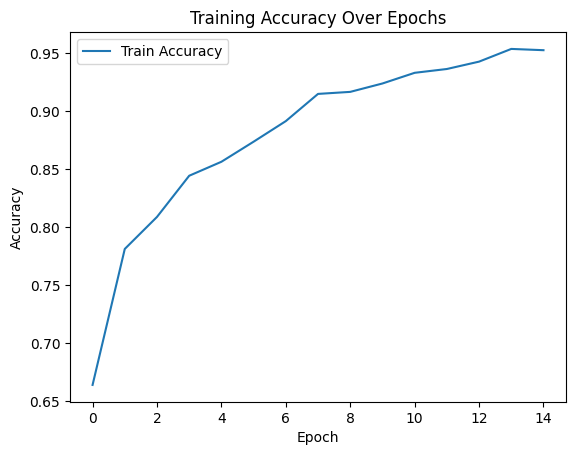

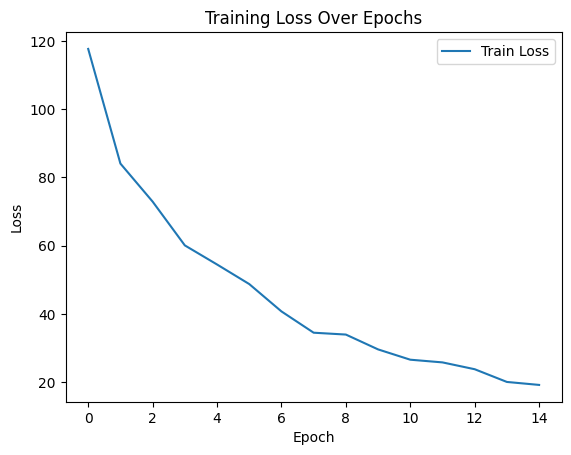

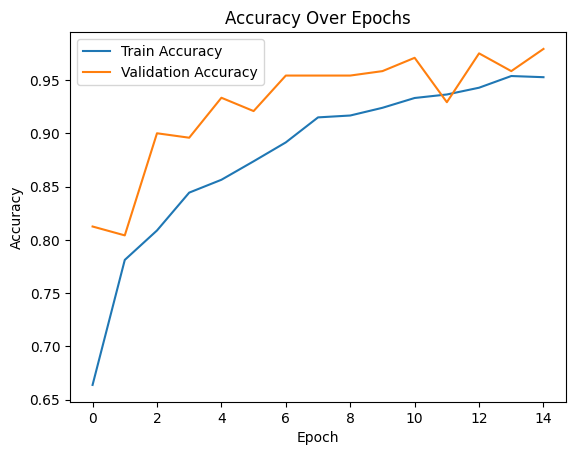

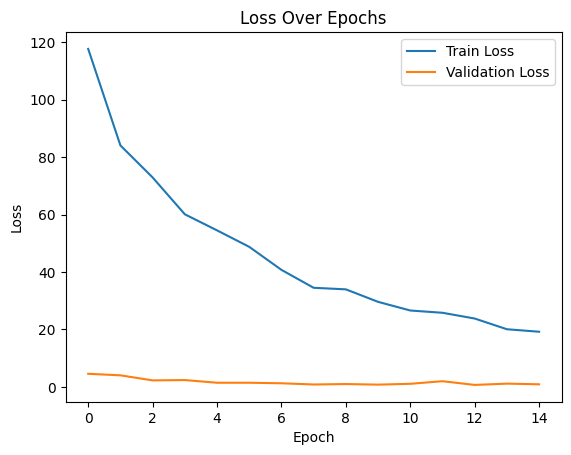

In [11]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
original_path = "../train"
augmented_path = "augmented_train_2"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])

# Load training and test datasets using folder structure
original_data = ImageFolder(original_path,transform=transform_train)
augmented_data = ImageFolder(augmented_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(original_data))
val_size = len(original_data) - train_size
original_train, val_dataset = random_split(original_data, [train_size,val_size])

from torch.utils.data import ConcatDataset
train_dataset = ConcatDataset([original_train,augmented_data])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", test_data.classes)

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),                                  # ReLU activation
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.3),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# Map class indices to class names
idx_to_class = {v: k for k, v in test_data.class_to_idx.items()}

# Store misclassified image info
misclassified_images = []

# Redefine test_loader to include image paths
from torchvision.datasets import ImageFolder
class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        original_tuple = super().__getitem__(index)
        path = self.imgs[index][0]
        return original_tuple + (path,)

test_data_with_paths = ImageFolderWithPaths(test_path, transform=transform_test)
test_loader_with_paths = DataLoader(test_data_with_paths, batch_size=32, shuffle=False)

# Collect misclassified images
model.eval()
with torch.no_grad():
    for images, labels, paths in test_loader_with_paths:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(preds)):
            if preds[i].item() != labels[i].item():
                misclassified_images.append({
                    "path": paths[i],
                    "true_label": idx_to_class[labels[i].item()],
                    "predicted_label": idx_to_class[preds[i].item()]
                })

# Print summary of misclassified images
print(f"\nTotal Misclassified Images: {len(misclassified_images)}")
for i, entry in enumerate(misclassified_images[:10]):  # Show top 10 only
    print(f"[{i+1}] File: {entry['path']} | True: {entry['true_label']} | Pred: {entry['predicted_label']}")


# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 3rd Run ##
**training data:** augmented_tain_3 & 70% of train

In [ ]:
# do augmentation
import os
from PIL import Image
import torchvision.transforms as transforms
import random
import torch

random.seed(42)
torch.manual_seed(42)

augmentation = transforms.Compose([
     transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomVerticalFlip(p=1.0),
    ], p=0.5),

    transforms.RandomApply([
        transforms.RandomRotation(degrees=30),
    ], p=0.8),

    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=10,              
            translate=(0.1, 0.1),
            scale=(0.95, 1.05),
            shear=5
        ),
    ], p=0.9),

    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.3,
            contrast=0.3,
            saturation=0.3,
            hue=0.02
        ),
    ], p=0.9),

    transforms.RandomApply([
        transforms.RandomGrayscale(p=1.0),
    ], p=0.05),

    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3),
    ], p=0.3),

    transforms.ToTensor(),

    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3)),

    transforms.ToPILImage()
])

# script_dir = os.path.dirname(os.path.abspath(__file__))
input_root = "../train"
output_root = "augmented_train_3"
aug_per_image = 5

if not os.path.exists(input_root):
    raise FileNotFoundError(f"input root not exist: {os.path.abspath(input_root)}")


for class_name in os.listdir(input_root):
    input_class_path = os.path.join(input_root, class_name)
    output_class_path = os.path.join(output_root, class_name)

    if not os.path.isdir(input_class_path):
        continue

    os.makedirs(output_class_path, exist_ok=True)

    for img_name in os.listdir(input_class_path):
        img_path = os.path.join(input_class_path, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"skip damage image: {img_path}")
            continue

        for i in range(aug_per_image):
            aug_img = augmentation(image)
            save_path = os.path.join(
                output_class_path,
                f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
            )
            aug_img.save(save_path)

Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 122.1404, Train Acc: 0.6636, Val Loss: 3.5804, Val Acc: 0.8500
Epoch 2, Train Loss: 85.7377, Train Acc: 0.7779, Val Loss: 2.5923, Val Acc: 0.8875
Epoch 3, Train Loss: 77.4842, Train Acc: 0.8046, Val Loss: 2.1402, Val Acc: 0.8708
Epoch 4, Train Loss: 68.7412, Train Acc: 0.8195, Val Loss: 1.6319, Val Acc: 0.9208
Epoch 5, Train Loss: 60.6784, Train Acc: 0.8351, Val Loss: 2.0686, Val Acc: 0.9125
Epoch 6, Train Loss: 51.8741, Train Acc: 0.8603, Val Loss: 1.9747, Val Acc: 0.9083
Epoch 7, Train Loss: 47.1420, Train Acc: 0.8776, Val Loss: 1.3561, Val Acc: 0.9333
Epoch 8, Train Loss: 41.8656, Train Acc: 0.8945, Val Loss: 1.0327, Val Acc: 0.9542
Epoch 9, Train Loss: 38.5353, Train Acc: 0.9022, Val Loss: 0.7993, Val Acc: 0.9583
Epoch 10, Train Loss: 32.4949, Train Acc: 0.9193, Val Loss: 0.8103, Val Acc: 0.9667
Epoch 11, Train Loss: 31.8545, Train Acc: 0.9230, Val Loss: 0.8736, Val Acc: 0.9667
Epoch 12, Train Lo

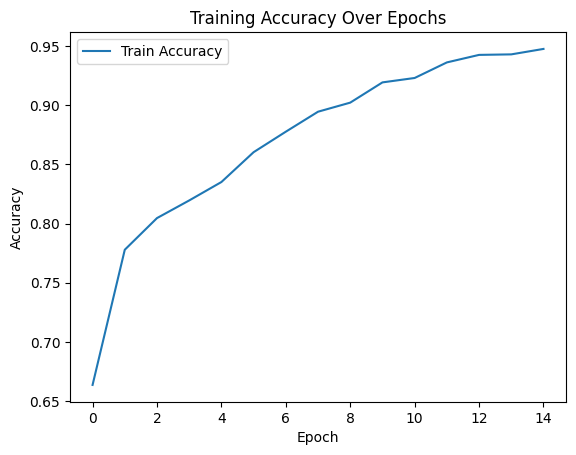

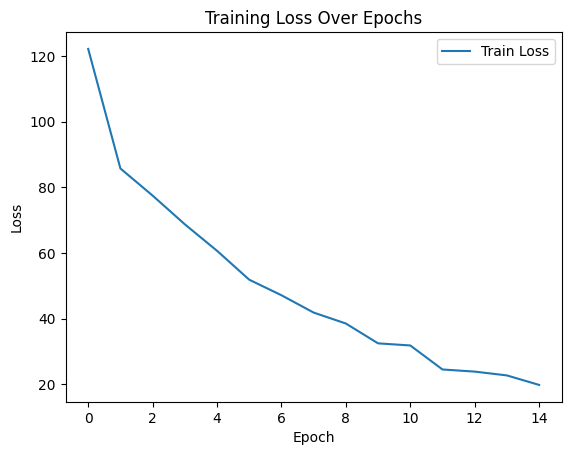

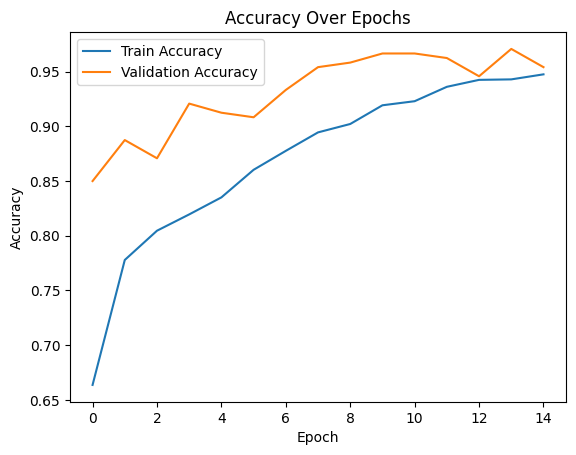

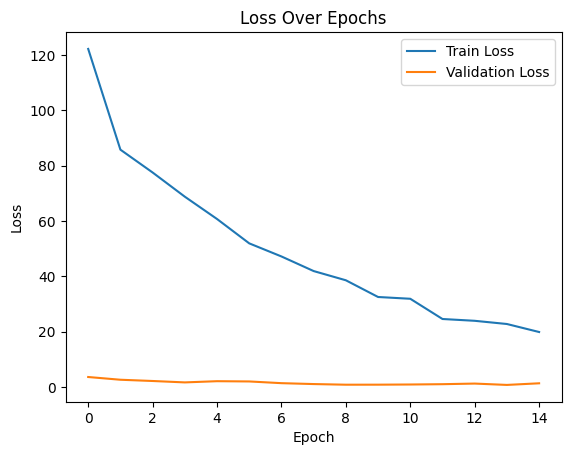

In [13]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
original_path = "../train"
augmented_path = "augmented_train_3"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])

# Load training and test datasets using folder structure
original_data = ImageFolder(original_path,transform=transform_train)
augmented_data = ImageFolder(augmented_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(original_data))
val_size = len(original_data) - train_size
original_train, val_dataset = random_split(original_data, [train_size,val_size])

from torch.utils.data import ConcatDataset
train_dataset = ConcatDataset([original_train,augmented_data])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", test_data.classes)

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),                                  # ReLU activation
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.3),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 15

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
